# Getting Started

This notebook uses Hyrax to train a small convolutional neural network to classify CIFAR data<sup>1</sup>.
It is based on the PyTorch example here: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In the interest of clarity, we will not perfectly reproduce the work in the PyTorch version, but we will still see the same results.
We will note where to make configuration changes in order to be perfectly faithful to the PyTorch version.

<sup>1</sup>[Learning multiple layers of features from tiny images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf) Alex Krizhevsky, 2009.

## Install Hyrax

Before we begin we'll need to install hyrax.
You can skip this step if you've running locally and have already installed Hyrax in your virtual environment.

In [ ]:
%pip install hyrax

## Create a hyrax instance

The main driver for Hyrax is the ``Hyrax`` class. To get started we'll create an instance of this class.

In [1]:
from hyrax import Hyrax

h = Hyrax()

## Specify a model

We'll need to let Hyrax know which model to use for training.
Here we’ll tell Hyrax to use the built-in HyraxCNN model that is based on the 
[simple CNN architecture](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network)
from the PyTorch CIFAR10 tutorial.
The Hyrax version of the model class is available on GitHub [here](https://github.com/lincc-frameworks/hyrax/blob/main/src/hyrax/models/hyrax_cnn.py).

Note: For a more faithful reproduction of the PyTorch example there are a few additional configuration parameters that can be set,
however we generally omit these both for clarity and because the default values reproduce the PyTorch results well:
```python
h.set_config("data_loader.batch_size", 4)  # Train with 4 data samples per batch
h.set_config("data_set.train_split", 1.0)  # Use all of the training data for training
h.set_config("data_set.validate_split", 0.0)  # Do not use any training data for validation
h.set_config("data_set.test_split", 0.0)  # Or for testing
h.set_config("'torch.optim.SGD'.lr", 0.001)  # Set the learning rate lower than the Hyrax default
h.set_config("train.epochs", 2)  # Only train for 2 epochs (instead of the default 10)
```

In [ ]:
h.set_config("model.name", "HyraxCNN")

## Defining the dataset

We’ll also need to tell Hyrax what data should be used for training, in this case the CIFAR10 dataset.
Hyrax has a built in dataset class for working with CIFAR10 data, so we’ll configure that here.
You can learn more about the CIFAR10 at the offical site: https://www.cs.toronto.edu/~kriz/cifar.html

This may appear overly verbose, especially for a simple case, but being explicit about the dataset configuration will allow for great flexibility down the line when working with more complex data.

In [ ]:
model_inputs_definition = {
    "train": {
        "data": {
            "dataset_class": "HyraxCifarDataset",
            "data_location": "./data",
            "fields": ["image", "label"],
            "primary_id_field": "object_id",
        },
    },
}

h.set_config("model_inputs", model_inputs_definition)

## Training the model

With the model and data specified,we're ready for training.
We'll use the ``train`` verb to kick off the training process.

In [ ]:
trained_model = h.train()

The output of training will be stored in a timestamped directory with a name similar to `.../YYYYmmdd-HHMMSS-train-xxxx/`.
This output directory will contain the saved model weights, full configuration, checkpoints, and any other information necessary to reproduce the work.

## Predicting with the model

Now that we've trained a model, we can use it to infer classes of samples from the CIFAR10 test dataset.
First we'll add to our model input definition to specify the data to use for inference.

In [ ]:
model_inputs_definition["infer"] = {
    "data": {
        "dataset_class": "HyraxCifarDataset",
        "data_location": "./data",
        "fields": ["image", "object_id"],
        "primary_id_field": "object_id",
        "dataset_config": {
            "use_training_data": False,
        },
    },
}

h.config["model_inputs"] = model_inputs_definition

Then we'll use Hyrax's ``infer`` verb to load the trained model weights and predict the classes of the data defined in the previous cell.

In [ ]:
inference_results = h.infer()

## Evaluating the performance

Let's compare the models predictions to the actual labels from the test dataset.
The model's prediction is a 10 element vector where the largest value represents the highest confidence class.
So we'll extract the index of the max value for each prediction and save that as `predicted_classes`.

In [ ]:
# get the index of the maximum predicted class for all test samples
import numpy as np

predicted_classes = np.zeros(len(inference_results)).astype(int)
for i in range(len(inference_results)):
    predicted_classes[i] = inference_results[i].argmax()

We'll also load the original test data to get access to the true labels.

In [8]:
import pickle

with open("./data/cifar-10-batches-py/test_batch", "rb") as fo:
    test_data = pickle.load(fo, encoding="bytes")

Finally we'll print the overall accuracy and use scikit-learn's ``confusion_matrix`` to display a nice confusion matrix.


Accuracy for test dataset: 0.5003


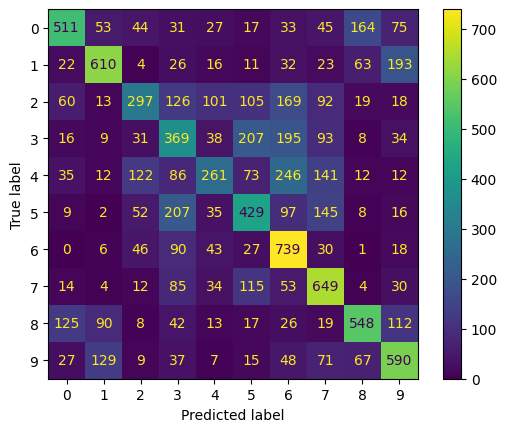

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_true = test_data[b"labels"]
y_pred = predicted_classes.tolist()

correct = 0
for t, p in zip(y_true, y_pred):
    correct += t == p

print("\nAccuracy for test dataset:", correct / len(y_true))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

The overall accuracy is around 50% - significantly better than random which would be 10%.
Accuracy of ~50% is in agreement with the [PyTorch example results](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#test-the-network-on-the-test-data).